In [94]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import openpyxl
from openpyxl import load_workbook
import os
from ccfj import GetStationPairs
from geopy.distance import great_circle
#import shapefile
import geopandas as gp
import yaml
import math

from scipy.spatial import ConvexHull
from scipy.interpolate import griddata
from shapely.geometry import Point, Polygon

from pykrige.ok import OrdinaryKriging


In [95]:
import sys
sys.path.append(r'../tools_F-J/')
from toollib_standard import plotlib

In [96]:
flag_project = 1 # 0--regular; 1--repartrition

In [97]:
if flag_project == 0:
    with open('a-project.yml', 'r', encoding='utf-8') as f:
        proj = yaml.load(f.read(), Loader=yaml.FullLoader) 
    #name_project = 'project/output_FJSJ_16-01/'               # Harmon server
elif flag_project == 1:
    with open('a-project_repar.yml', 'r', encoding='utf-8') as f:
        proj = yaml.load(f.read(), Loader=yaml.FullLoader)
    #name_project = 'project_repartrition/repartrition_01-03/' 
name_project = proj['name']              # Harmon server

In [98]:
with open('0_config.yml', 'r', encoding='utf-8') as f:
    dir_config = yaml.load(f.read(), Loader=yaml.FullLoader)
dir_project_workspace = dir_config['dir_project_workspace']
dir_CC_workspace = dir_config['dir_CC_workspace']
print('dir_CC_workspace: ', dir_CC_workspace)
print('dir_project_workspace: ', dir_project_workspace)
dir_project = os.path.join(dir_project_workspace, name_project)
print('dir_project: ', dir_project)

dir_CC_workspace:  /shdisk/rem2/Harmon/F-J/San/
dir_project_workspace:  /shdisk/rem2/Harmon/F-J/San/
dir_project:  /shdisk/rem2/Harmon/F-J/San/project_repartition_v4.0/output_repar_v9.2_01-01/


In [99]:
filename = dir_project+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project+'Basic_info.npy'
info_basic_bi = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

In [100]:
flag_over = 0

In [101]:
if flag_over == 0:
    dir_model = dir_project + info_basic['dir_model_fund']
    dir_image = dir_project + info_basic['dir_image']+'Vs_fund_test/'
else:
    dir_model = dir_project + info_basic['dir_model']
    dir_image = dir_project + info_basic['dir_image']+'Vs_over/'
if not os.path.exists(dir_image):
    os.makedirs(dir_image)
dir_inv_dispernet = dir_project + info_basic['dir_inv_dispernet']
dir_partition = dir_project + info_basic['dir_partition']
key_subworks = info_basic['key_subworks']
M = len(key_subworks)
key_subworks

['1--08-03',
 '2--09-03',
 '3--10-03',
 '4--11-03',
 '5--12-03',
 '6--13-03',
 '7--14-03',
 '8--15-03',
 '9--16-03',
 '10--18-03',
 '12--20-03',
 '13--21-03',
 '15--23-03',
 '17--25-03',
 '18--26-03',
 '19--27-03',
 '20--28-03',
 '21--29-03',
 '22--30-03',
 '23--31-03',
 '25--33-03',
 '26--34-03',
 '28--36-03',
 '30--41-03',
 '31--42-03',
 '33--46-03',
 '34--47-03',
 '35--48-03',
 '36--52-03',
 '37--53-03',
 '38--07-04',
 '39--08-04',
 '40--09-04',
 '41--10-04',
 '42--12-04',
 '43--13-04',
 '44--17-04',
 '45--20-04',
 '46--21-04',
 '48--23-04',
 '49--24-04',
 '50--25-04',
 '51--27-04',
 '52--28-04',
 '53--29-04',
 '54--30-04',
 '55--31-04',
 '56--32-04',
 '57--33-04',
 '58--34-04',
 '59--35-04',
 '60--36-04',
 '63--47-04',
 '65--49-04',
 '66--52-04',
 '67--53-04',
 '68--08-05',
 '69--12-05',
 '70--13-05',
 '71--14-05',
 '72--16-05',
 '75--22-05',
 '76--24-05',
 '77--26-05',
 '78--27-05',
 '79--28-05',
 '80--29-05',
 '81--30-05',
 '84--35-05',
 '85--36-05',
 '86--37-05',
 '88--39-05',
 

In [102]:
stalistname_all = info_basic['stalistname_all']
stainfo = pd.read_excel(stalistname_all)
nsta_all = len(stainfo.iloc[:,0])
StationPairs_all = GetStationPairs(nsta_all)
nPairs_all = int(len(StationPairs_all)/2)
stalist_all = stainfo['Station'].tolist() 
lat_stations_all =  stainfo['latitude'].tolist() 
lon_stations_all =  stainfo['longitude'].tolist() 
elevation_stations_all = stainfo['elevation'].tolist()

In [103]:
stations_partition = {}
lat_stations_partition = {}
lon_stations_partition = {}
lat_centroid_partition = []
lon_centroid_partition = []
num_stations = []
for key in key_subworks:
    filepath = dir_partition + str(key) + '.txt'
    stations_this, lat_stations_this, lon_stations_this = np.loadtxt(filepath, dtype='str' , unpack=True)
    stations_partition[key] = stations_this
    lat_stations_partition[key] = lat_stations_this.astype(float)
    lon_stations_partition[key] = lon_stations_this.astype(float)
    num_stations.append(len(stations_this))
    lat_centroid_partition.append(np.mean(lat_stations_this.astype(float)))
    lon_centroid_partition.append(np.mean(lon_stations_this.astype(float)))

In [104]:
faults = np.load('clark_faults.npy', allow_pickle='TRUE').item()

### Interpolate 3D structure

In [105]:
struc = {}
flag = 0
for key_subwork in key_subworks:
    file_model = dir_model + 'model_'+key_subwork+'.txt'
    model = np.loadtxt(file_model)
    struc[key_subwork] = {}
    struc[key_subwork]['layer'] = model[:, 0]
    struc[key_subwork]['z'] = model[:, 1]
    struc[key_subwork]['rho'] = model[:, 2]
    struc[key_subwork]['vs'] = model[:, 3]
    struc[key_subwork]['vp'] = model[:, 4]
    struc[key_subwork]['std'] = model[:, 5]
    flag += 1
    print('Read structure model: %s (%d/%d)' % (key_subwork, flag, M))

vs_horizon = {}
dz = 5
N = 40
for i in range(N):
    vs_horizon[i] = []
    for key_subwork in key_subworks:
        vs_horizon[i].append(struc[key_subwork]['vs'][i])

Read structure model: 1--08-03 (1/466)
Read structure model: 2--09-03 (2/466)
Read structure model: 3--10-03 (3/466)
Read structure model: 4--11-03 (4/466)
Read structure model: 5--12-03 (5/466)
Read structure model: 6--13-03 (6/466)
Read structure model: 7--14-03 (7/466)
Read structure model: 8--15-03 (8/466)
Read structure model: 9--16-03 (9/466)
Read structure model: 10--18-03 (10/466)
Read structure model: 12--20-03 (11/466)
Read structure model: 13--21-03 (12/466)
Read structure model: 15--23-03 (13/466)
Read structure model: 17--25-03 (14/466)
Read structure model: 18--26-03 (15/466)
Read structure model: 19--27-03 (16/466)
Read structure model: 20--28-03 (17/466)
Read structure model: 21--29-03 (18/466)
Read structure model: 22--30-03 (19/466)
Read structure model: 23--31-03 (20/466)
Read structure model: 25--33-03 (21/466)
Read structure model: 26--34-03 (22/466)
Read structure model: 28--36-03 (23/466)
Read structure model: 30--41-03 (24/466)
Read structure model: 31--42-03 (2

In [106]:
num_lons = 100
num_lats = 100
dz = 5
N = 40
type_interp = 'linear'

v_min = 0.3
v_max = 0.65

In [107]:
# generate grid
xx = np.linspace(np.min(lon_centroid_partition), np.max(lon_centroid_partition), num_lons)
yy = np.linspace(np.min(lat_centroid_partition), np.max(lat_centroid_partition), num_lats)
A,B = np.meshgrid(xx, yy)
X_star = np.hstack((A.flatten()[:,None], B.flatten()[:,None]))
lon_grid = X_star[:,0]
lat_grid = X_star[:,1]
# cut
points = np.column_stack((lon_centroid_partition, lat_centroid_partition))
hull = ConvexHull(points)
polygon = Polygon(points[hull.vertices])
index = []
lon_inter_in = []
lat_inter_in = []
for i in range(len(lon_grid)):
    if polygon.contains(Point(lon_grid[i], lat_grid[i])):
        index.append(i)
        lon_inter_in.append(lon_grid[i])
        lat_inter_in.append(lat_grid[i])

In [108]:
# Elevation interpolation
xx_sta = np.linspace(np.min(lon_stations_all), np.max(lon_stations_all), num_lons)
yy_sta = np.linspace(np.min(lat_stations_all), np.max(lat_stations_all), num_lats)
A,B = np.meshgrid(xx_sta, yy_sta)
X_star = np.hstack((A.flatten()[:,None], B.flatten()[:,None]))
lon_grid_ele = X_star[:,0]
lat_grid_ele = X_star[:,1]

#points = np.column_stack((lon_stations_all, lat_stations_all))
points = np.column_stack((lon_centroid_partition, lat_centroid_partition))
hull = ConvexHull(points)
polygon = Polygon(points[hull.vertices])
index_sta = []
lon_sta_inter_in = []
lat_sta_inter_in = []
for i in range(len(lon_grid_ele)):
    if polygon.contains(Point(lon_grid_ele[i], lat_grid_ele[i])):
        index_sta.append(i)
        lon_sta_inter_in.append(lon_grid_ele[i])
        lat_sta_inter_in.append(lat_grid_ele[i])



OK = OrdinaryKriging(lon_stations_all, lat_stations_all, elevation_stations_all, variogram_model=type_interp,nlags=3)
zz,ss = OK.execute('grid', xx_sta, yy_sta)
elevation_inter_in = zz.reshape(len(xx_sta)*len(yy_sta))[index_sta]

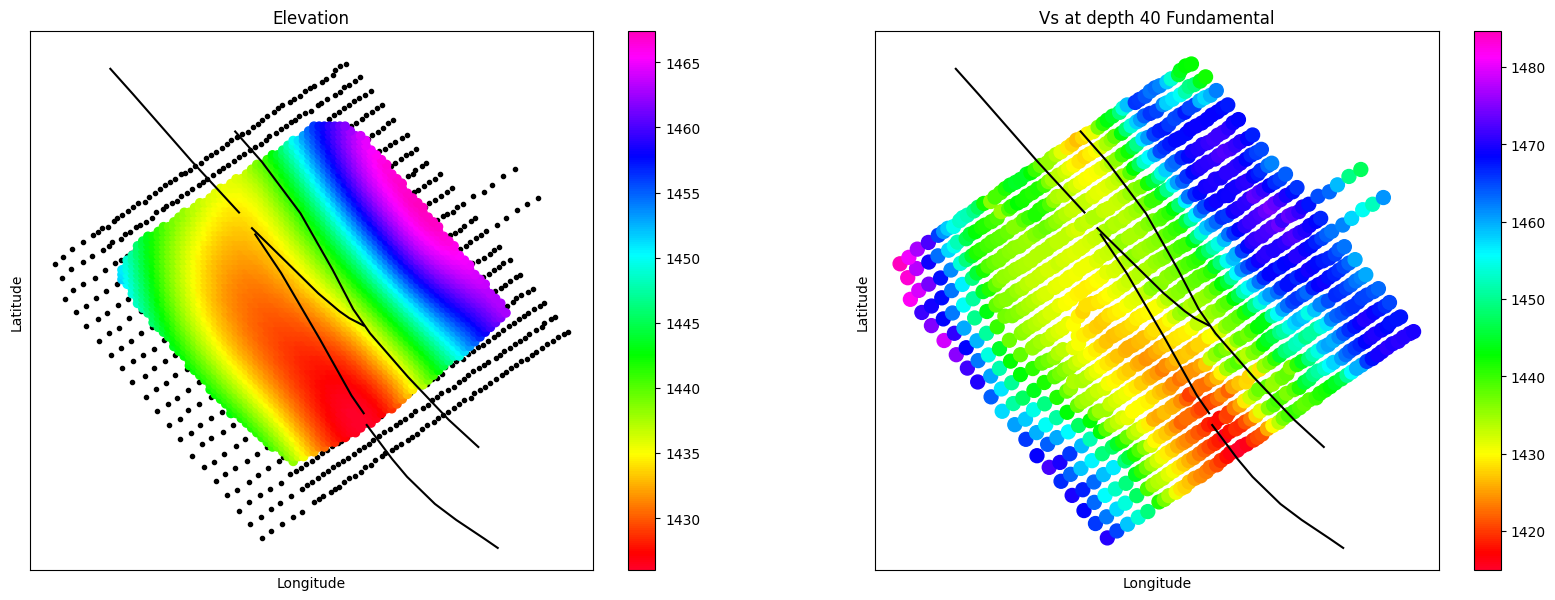

In [126]:
fig = plt.figure(figsize=(20, 7))
ax = fig.add_subplot(121)
ax.scatter(lon_stations_all, lat_stations_all,marker='.',color='k')
#ax.set_xticks([])  #去掉横坐标值
#ax.set_yticks([])  #去掉纵坐标值
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Vs at depth '+str((i+1)*dz)+' Fundamental')
flag_add = 0.0005
ax.set_xlim([min(lon_stations_all)-flag_add, max(lon_stations_all)+flag_add])
ax.set_ylim([min(lat_stations_all)-flag_add, max(lat_stations_all)+flag_add])
for j in range(len(faults)):
    ax.plot(faults['clark'+str(j+1)]['lon'], faults['clark'+str(j+1)]['lat'], 'k')
#im = ax.scatter(lon_centroid_partition,lat_centroid_partition,c=vs_horizon[i],cmap='gist_rainbow',s=100)
im = ax.scatter(lon_sta_inter_in,lat_sta_inter_in, c = elevation_inter_in,cmap='gist_rainbow' )
plt.colorbar(im)
ax.set_xticks([])  #去掉横坐标值
ax.set_yticks([])  #去掉纵坐标值
ax.set_title('Elevation')

ax  = fig.add_subplot(122)
ax.scatter(lon_stations_all, lat_stations_all,marker='.',color='k')
ax.set_xticks([])  #去掉横坐标值
ax.set_yticks([])  #去掉纵坐标值
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Vs at depth '+str((i+1)*dz)+' Fundamental')
flag_add = 0.0005
ax.set_xlim([min(lon_stations_all)-flag_add, max(lon_stations_all)+flag_add])
ax.set_ylim([min(lat_stations_all)-flag_add, max(lat_stations_all)+flag_add])
for j in range(len(faults)):
    ax.plot(faults['clark'+str(j+1)]['lon'], faults['clark'+str(j+1)]['lat'], 'k')
im = ax.scatter(lon_stations_all,lat_stations_all,c=elevation_stations_all,cmap='gist_rainbow',s=100)
plt.colorbar(im)

In [110]:
# Vs interpolation
vs_inter_horizon_all = {}
vs_inter_horizon_in = {}
for i in range(N):
    print('Interpolating horizon %d' % i)
    OK = OrdinaryKriging(lon_centroid_partition, lat_centroid_partition, vs_horizon[i], variogram_model=type_interp,nlags=3)
    zz,ss = OK.execute('grid', xx, yy)
    vs_inter_horizon_all[i] = zz.reshape(len(xx)*len(yy))
    vs_inter_horizon_in[i] = zz.reshape(len(xx)*len(yy))[index]

Interpolating horizon 0
Interpolating horizon 1
Interpolating horizon 2
Interpolating horizon 3
Interpolating horizon 4
Interpolating horizon 5
Interpolating horizon 6
Interpolating horizon 7
Interpolating horizon 8
Interpolating horizon 9
Interpolating horizon 10
Interpolating horizon 11
Interpolating horizon 12
Interpolating horizon 13
Interpolating horizon 14
Interpolating horizon 15
Interpolating horizon 16
Interpolating horizon 17
Interpolating horizon 18
Interpolating horizon 19
Interpolating horizon 20
Interpolating horizon 21
Interpolating horizon 22
Interpolating horizon 23
Interpolating horizon 24
Interpolating horizon 25
Interpolating horizon 26
Interpolating horizon 27
Interpolating horizon 28
Interpolating horizon 29
Interpolating horizon 30
Interpolating horizon 31
Interpolating horizon 32
Interpolating horizon 33
Interpolating horizon 34
Interpolating horizon 35
Interpolating horizon 36
Interpolating horizon 37
Interpolating horizon 38
Interpolating horizon 39


### Do clipper

In [111]:
# define traces
traces = {}
for i in range(3,17):
    traces[i] = np.zeros([2,2])
    sta_start = 'R'+'20'+str(i).zfill(2)
    sta_end = 'R'+'30'+str(i).zfill(2)
    if sta_start not in stalist_all:
        print('Warning: start station %s not found' % sta_start)
    if sta_end not in stalist_all:
        print('Warning: end station %s not found' % sta_end)
    traces[i][0,0] = lon_stations_all[stalist_all.index(sta_start)]
    traces[i][0,1] = lat_stations_all[stalist_all.index(sta_start)]
    traces[i][1,0] = lon_stations_all[stalist_all.index(sta_end)]
    traces[i][1,1] = lat_stations_all[stalist_all.index(sta_end)]

In [112]:
def extract_points(tag_trace,xx,yy,lon_inter_in,lat_inter_in):
    global traces
    trace = traces[tag_trace]

    x1 = trace[0,0]
    y1 = trace[0,1]
    x2 = trace[1,0]
    y2 = trace[1,1]
    A = (y2-y1)/(x2-x1)
    B = -1
    C = y2 - A*x2

    flag_r = np.sqrt(( (xx[1]-xx[0])**2 + (yy[1]-yy[0])**2 ))/2
    index = []
    
    for i in range(len(lon_inter_in)):
        x0 = lon_inter_in[i]
        y0 = lat_inter_in[i]
        d = abs(A*x0+B*y0+C)/math.sqrt(A**2+B**2)
        if d <= flag_r:
            index.append(i)
    return index

In [113]:
def find_intersection_point(point1_line, point2_line, external_point):
    # 计算直线的斜率
    line_slope = (point2_line[1] - point1_line[1]) / (point2_line[0] - point1_line[0])

    # 计算直线的截距
    line_intercept = point1_line[1] - line_slope * point1_line[0]

    # 计算垂线的斜率
    perpendicular_slope = -1 / line_slope

    # 计算垂线的截距
    perpendicular_intercept = external_point[1] - perpendicular_slope * external_point[0]

    # 求解方程组以找到交点
    intersection_x = (perpendicular_intercept - line_intercept) / (line_slope - perpendicular_slope)
    intersection_y = line_slope * intersection_x + line_intercept

    return intersection_x, intersection_y

In [114]:
lon_inter_verti = {}
lat_inter_verti = {}
lon_ele_inter_verti = {}
lat_ele_inter_verti = {}
vs_inter_verti = {}
ele_inter_verti = {}
r = {}
r_ele = {}
indexes = {}
indexes_ele = {}
loc_starts = {}
loc_ele_starts = {}
for tag in traces.keys():
    index = extract_points(tag,xx,yy,lon_inter_in,lat_inter_in)
    indexes[tag] = index
    index_ele = extract_points(tag,xx_sta,yy_sta,lon_sta_inter_in,lat_sta_inter_in)
    indexes_ele[tag] = index_ele
    lon_inter_verti[tag] = np.array(lon_inter_in)[index]
    lat_inter_verti[tag] = np.array(lat_inter_in)[index]
    lon_ele_inter_verti[tag] = np.array(lon_sta_inter_in)[index_ele]
    lat_ele_inter_verti[tag] = np.array(lat_sta_inter_in)[index_ele]
    r[tag] = np.zeros(len(index))
    r[tag][0] = 0
    r_ele[tag] = np.zeros(len(index_ele))
    r_ele[tag][0] = 0
    vs_inter_verti[tag] = []
    ele_inter_verti[tag] = []
    loc_start = find_intersection_point(traces[tag][0], traces[tag][1], [lon_inter_verti[tag][0], lat_inter_verti[tag][0]])
    loc_ele_start = find_intersection_point(traces[tag][0], traces[tag][1], [lon_inter_verti[tag][0], lat_inter_verti[tag][0]])
    loc_starts[tag] = loc_start
    loc_ele_starts[tag] = loc_ele_start
    for i in range(N):
        vs_inter_verti[tag].append(vs_inter_horizon_in[i][index])
    ele_inter_verti[tag].append(elevation_inter_in[index_ele])
    for i in range(len(index)):
        if i > 0:
            loc_new = find_intersection_point(traces[tag][0], traces[tag][1], [lon_inter_verti[tag][i], lat_inter_verti[tag][i]])
            r[tag][i] = np.sqrt((loc_new[0]-loc_start[0])**2 + (loc_new[1]-loc_start[1])**2)
    for i in range(len(index_ele)):
        if i > 0:
            loc_new = find_intersection_point(traces[tag][0], traces[tag][1], [lon_ele_inter_verti[tag][i], lat_ele_inter_verti[tag][i]])
            r_ele[tag][i] = np.sqrt((loc_new[0]-loc_ele_start[0])**2 + (loc_new[1]-loc_ele_start[1])**2)

In [115]:
# 判断两条线段是否相交
def cross_product(p1, p2, p3):
    """计算叉积"""
    return (p2[0] - p1[0]) * (p3[1] - p1[1]) - (p2[1] - p1[1]) * (p3[0] - p1[0])

def on_segment(p1, p2, p3):
    """检查p2是否在以p1和p3为端点的线段上"""
    return min(p1[0], p3[0]) <= p2[0] <= max(p1[0], p3[0]) and min(p1[1], p3[1]) <= p2[1] <= max(p1[1], p3[1])

def segments_intersect(p1, q1, p2, q2):
    """检查由(p1, q1)和(p2, q2)形成的两条线段是否相交"""
    # 检查线段的方向
    o1 = cross_product(p1, q1, p2)
    o2 = cross_product(p1, q1, q2)
    o3 = cross_product(p2, q2, p1)
    o4 = cross_product(p2, q2, q1)

    # 如果两条线段的方向相异，则它们相交
    if o1 * o2 < 0 and o3 * o4 < 0:
        return True
    # 特殊情况处理
    if o1 == 0 and on_segment(p1, p2, q1):
        return True
    if o2 == 0 and on_segment(p1, q2, q1):
        return True
    if o3 == 0 and on_segment(p2, p1, q2):
        return True
    if o4 == 0 and on_segment(p2, q1, q2):
        return True

    return False

def plot_segments(p1, q1, p2, q2):
    plt.plot([p1[0], q1[0]], [p1[1], q1[1]], color='blue', label='Segment 1')
    plt.plot([p2[0], q2[0]], [p2[1], q2[1]], color='red', label='Segment 2')

    intersection = segments_intersect(p1, q1, p2, q2)

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Segments Intersection')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()

In [116]:
# 找到两条线段的交点
def find_lines_inter(p1, q1, p2, q2):
    if segments_intersect(p1, q1, p2, q2):
        # 计算直线的斜率
        line1_slope = (q1[1] - p1[1]) / (q1[0] - p1[0])
        line2_slope = (q2[1] - p2[1]) / (q2[0] - p2[0])

        # 计算直线的截距
        line1_intercept = p1[1] - line1_slope * p1[0]
        line2_intercept = p2[1] - line2_slope * p2[0]

        # 求解方程组以找到交点
        intersection_x = (line2_intercept - line1_intercept) / (line1_slope - line2_slope)
        intersection_y = line1_slope * intersection_x + line1_intercept

        return intersection_x, intersection_y
    else:
        return None

In [117]:
def find_fault_inter(tag_trace):
    global traces
    global faults
    global lon_inter_verti
    global lat_inter_verti

    lat_fault_inter = []
    lon_fault_inter = []

    for key in faults.keys():
        lon_fault = faults[key]['lon']
        lat_fault = faults[key]['lat']  
        index_fault_start = np.argmin(lon_fault)
        index_fault_end = np.argmax(lon_fault)
        p1 = [lon_fault[index_fault_start], lat_fault[index_fault_start]]
        q1 = [lon_fault[index_fault_end], lat_fault[index_fault_end]]
        index_trace_start = np.argmin(lon_inter_verti[tag_trace])
        index_trace_end = np.argmax(lon_inter_verti[tag_trace])
        p2 = [lon_inter_verti[tag_trace][index_trace_start], lat_inter_verti[tag_trace][index_trace_start]]
        q2 = [lon_inter_verti[tag_trace][index_trace_end], lat_inter_verti[tag_trace][index_trace_end]]
        intersection = find_lines_inter(p1, q1, p2, q2)
        if intersection is not None:
            lon_fault_inter.append(intersection[0])
            lat_fault_inter.append(intersection[1])
    return lon_fault_inter, lat_fault_inter

Plotting trace 7


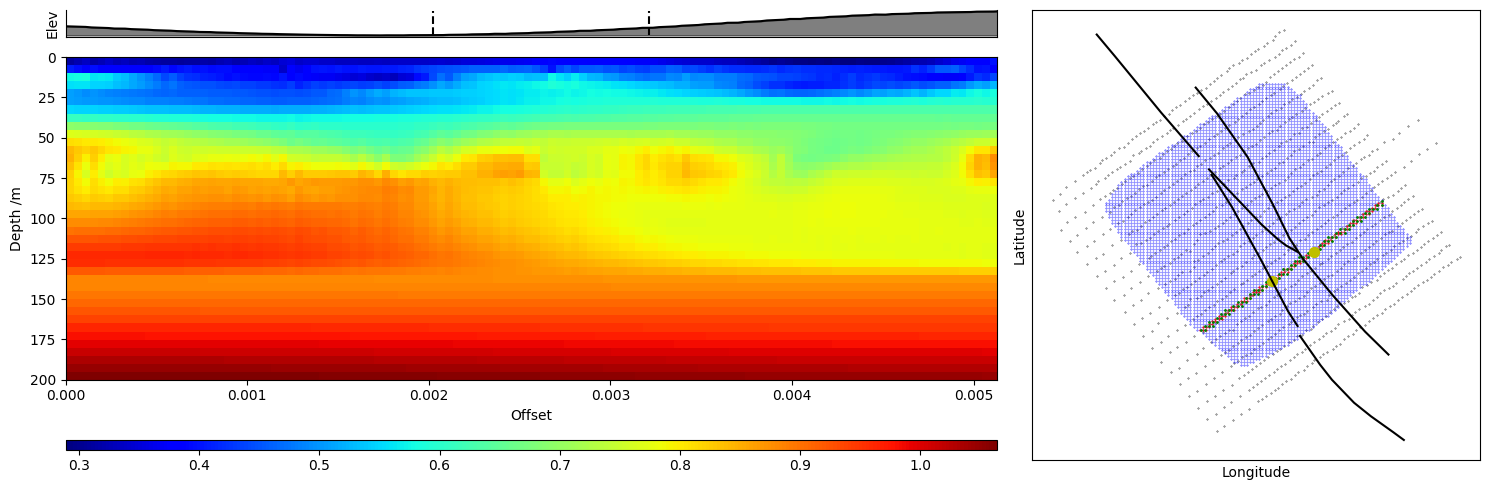

In [124]:
for i in range(7,8):
    print('Plotting trace %d' % i)
    fig = plt.figure(figsize=(15, 5))
    ax1 = plt.subplot2grid((10,3),(1,0),colspan=2,rowspan=9)
    im = ax1.imshow(vs_inter_verti[i], aspect='auto', cmap='jet', extent=[0,max(r[i]),N*dz,0])
    #ax1.set_xticks([])  #去掉横坐标值
    ax1.set_xlabel('Offset')
    ax1.set_ylabel('Depth /m')
    plt.colorbar(im,orientation='horizontal',aspect=100,fraction=0.05)
    # 找到断层点
    lon_fault_inter, lat_fault_inter = find_fault_inter(i)
    r_fault = []


    ax2 = plt.subplot2grid((1,3),(0,2),colspan=1,rowspan=1)
    ax2.scatter(lon_stations_all, lat_stations_all, c='k', s=0.08)
    for j in range(len(faults)):
        ax2.plot(faults['clark'+str(j+1)]['lon'], faults['clark'+str(j+1)]['lat'], 'k')
    ax2.scatter(lon_inter_in, lat_inter_in, c='b', s=0.1)
    ax2.scatter(np.array(lon_inter_in)[indexes[i]], np.array(lat_inter_in)[indexes[i]], c='r', s=0.3)
    ax2.scatter(np.array(lon_sta_inter_in)[indexes_ele[i]], np.array(lat_sta_inter_in)[indexes_ele[i]], c='g', s=1)
    ax2.scatter(lon_fault_inter, lat_fault_inter, c='y', s=50)

    ax2.set_xticks([])  #去掉横坐标值
    ax2.set_yticks([])  #去掉纵坐标值
    ax2.set_xlabel('Longitude')
    ax2.set_ylabel('Latitude')
    plt.tight_layout()

    axele = plt.subplot2grid((10,3),(0,0),colspan=2,rowspan=1)
    axele.set_xticks([])  #去掉横坐标值
    axele.set_yticks([])  #去掉纵坐标值
    axele.set_ylabel('Elev')
    axele.spines['top'].set_visible(False)
    # 画ele的柱状图
    #axele.bar(r_ele[i], ele_inter_verti[i][0]-min(ele_inter_verti[i][0]), width=0.1, color='g')
    index_r = np.argsort(r_ele[i])
    axele.plot(r_ele[i][index_r], ele_inter_verti[i][0][index_r]-min(ele_inter_verti[i][0]), color='k')
    axele.fill_between(r_ele[i][index_r], 0, ele_inter_verti[i][0][index_r]-min(ele_inter_verti[i][0]), color='k', alpha=0.5)
    for j in range(len(lon_fault_inter)):
        r_fault.append(np.sqrt((loc_starts[i][0]-lon_fault_inter[j])**2 + (loc_starts[i][1]-lat_fault_inter[j])**2))
        #ax1.scatter(r_fault[j],0, c='k', s=50)
        axele.vlines(r_fault[j], 0, max(ele_inter_verti[i][0][index_r]-min(ele_inter_verti[i][0])), colors = "k", linestyles = "dashed")
    axele.set_xlim([0, max(r[i])])
    #plt.savefig(dir_image+'Vs_verticle_trace_'+str(i)+'.png')
    #plt.close()

In [119]:
plt.plot

<function matplotlib.pyplot.plot(*args: 'float | ArrayLike | str', scalex: 'bool' = True, scaley: 'bool' = True, data=None, **kwargs) -> 'list[Line2D]'>

In [120]:
np.array(ele_inter_verti[i][0])
1= =1a

SyntaxError: cannot assign to literal (2821331881.py, line 2)

In [ ]:
ele_inter_verti[i][0]-min(ele_inter_verti[i][0])

masked_array(data=[12.489604576544025, 7.754037102645043,
                   4.7006007392164975, 1.5223064051899655,
                   0.6967760652005381, 0.0, 1.0390311908909098,
                   4.0007341101752445, 8.089717933956308,
                   12.69116615123221, 18.878299480349824,
                   24.897522640932266, 24.715929386276684,
                   30.210752250887936, 33.598993234227464,
                   36.72567111928083],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False],
       fill_value=1e+20)

In [ ]:
for i in traces.keys():
    print('Plotting trace %d' % i)
    fig = plt.figure(figsize=(15, 5))
    ax1 = plt.subplot2grid((1,3),(0,0),colspan=2,rowspan=1)
    im = ax1.imshow(vs_inter_verti[i], aspect='auto', cmap='jet', extent=[0,max(r[i]),N*dz,0])
    #ax1.set_xticks([])  #去掉横坐标值
    ax1.set_xlabel('Offset')
    ax1.set_ylabel('Depth /m')
    plt.colorbar(im)
    # 找到断层点
    lon_fault_inter, lat_fault_inter = find_fault_inter(i)
    r_fault = []
    for j in range(len(lon_fault_inter)):
        r_fault.append(np.sqrt((loc_starts[i][0]-lon_fault_inter[j])**2 + (loc_starts[i][1]-lat_fault_inter[j])**2))
        #ax1.scatter(r_fault[j],0, c='k', s=50)
        ax1.vlines(r_fault[j], 0, N/10*dz, colors = "k", linestyles = "dashed")


    ax2 = plt.subplot2grid((1,3),(0,2),colspan=1,rowspan=1)
    ax2.scatter(lon_stations_all, lat_stations_all, c='k', s=0.08)
    for j in range(len(faults)):
        ax2.plot(faults['clark'+str(j+1)]['lon'], faults['clark'+str(j+1)]['lat'], 'k')
    ax2.scatter(lon_inter_in, lat_inter_in, c='b', s=0.1)
    ax2.scatter(np.array(lon_inter_in)[indexes[i]], np.array(lat_inter_in)[indexes[i]], c='r', s=0.3)
    ax2.scatter(lon_fault_inter, lat_fault_inter, c='y', s=50)

    ax2.set_xticks([])  #去掉横坐标值
    ax2.set_yticks([])  #去掉纵坐标值
    ax2.set_xlabel('Longitude')
    ax2.set_ylabel('Latitude')
    plt.tight_layout()
    plt.savefig(dir_image+'Vs_verticle_trace_'+str(i)+'.png')
    plt.close()

Plotting trace 3
Plotting trace 4
Plotting trace 5
Plotting trace 6
Plotting trace 7
Plotting trace 8
Plotting trace 9
Plotting trace 10
Plotting trace 11
Plotting trace 12
Plotting trace 13
Plotting trace 14
Plotting trace 15
Plotting trace 16
